In [1]:
import seaborn as sns
import pandas as pd
import kneed
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from time import time
import numpy as np

## Experimental parameters

In [2]:
# biasDegree = 
# classImbalanceDegree = 
sizeOfLabeledSet = 0.025
# biasMechanism = 


# Import data

In [3]:
def read_file(url):

    url = url + "?raw=true"
    df = pd.read_csv(url, encoding='cp1252', sep=',', low_memory=False)
    return df

In [4]:
url = "https://github.com/hannahgathu/Thesis-Data-Visualisations/blob/main/Data/dielectron_classification.csv"

df= read_file(url)

# Visualize data

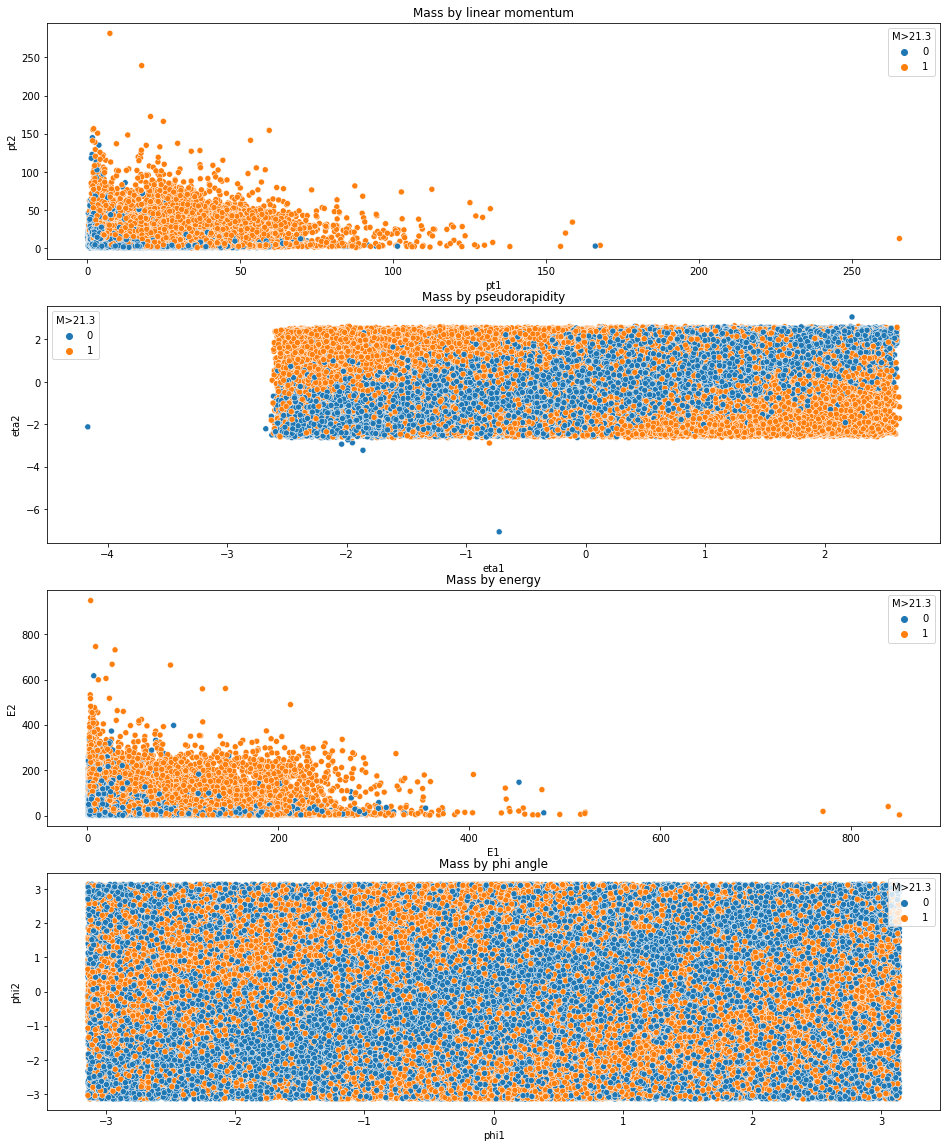

In [5]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=df, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=df, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=df, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=df, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

# Add bias

## Train classifier on whole dataset

### Prep and split data

In [6]:
y=df.M>21.3
#additional to dropping the endpoints we also drop the run and event numbers, because those aren't predictors
X=df.drop(columns=['M>21.3','M','Run','Event'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X,y,test_size=0.7, random_state=42)
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X,y,test_size=0.9, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,y,test_size=0.98, random_state=42)

### Tune hyperparameters

In [7]:
rf = RandomForestClassifier()
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


**Create random hyperparameter grid** 

In [8]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


**Random search training**

In [9]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_10, y_train_10)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = metrics.accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy =', accuracy)
    
    return accuracy

base_model = RandomForestClassifier(random_state = 42)
base_model.fit(X_train_10, y_train_10)
base_accuracy = evaluate(base_model, X_test_10, y_test_10)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_10, y_test_10)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


In [ ]:
base_model_2 = RandomForestClassifier(random_state = 42)
base_model_2.fit(X_train_2, y_train_2)
base_accuracy = evaluate(base_model_2, X_test_2, y_test_2)

In [ ]:
rf_random_2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_2.fit(X_train_2, y_train_2)

In [ ]:
rf_random_2.best_params_

In [ ]:
base_accuracy_2 = base_accuracy
best_random_2 = rf_random_2.best_estimator_
random_accuracy_2 = evaluate(best_random_2, X_test_2, y_test_2)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy_2 - base_accuracy_2) / base_accuracy_2))

### Train RF classifier

In [ ]:
rf = RandomForestClassifier()
t0 = time()
rf.fit(X_train, y_train)
print ('training time: ', round(time()-t0, 3), 's')

In [ ]:
rf_30 = RandomForestClassifier()
t0 = time()
rf_30.fit(X_train_30, y_train_30)
print ('training time: ', round(time()-t0, 3), 's')

In [ ]:
rfWhole = RandomForestClassifier()
t0 = time()
rfWhole.fit(X, y)
print ('training time: ', round(time()-t0, 3), 's')
t1=time()

In [13]:
rf_10 = RandomForestClassifier()
t0 = time()
rf_10.fit(X_train_10, y_train_10)
print ('training time: ', round(time()-t0, 3), 's')

training time:  2.113 s


In [ ]:
rf_2 = RandomForestClassifier()
t0 = time()
rf_2.fit(X_train_2, y_train_2)
print ('training time: ', round(time()-t0, 3), 's')

### Calculate accuracy

In [ ]:
t1=time()
pred_rf = rf.predict(X_test)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_test, pred_rf))

In [ ]:
t1=time()
pred_rf_30 = rf_30.predict(X_test_30)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_test_30, pred_rf_30))

In [ ]:
t1=time()
pred_rf_whole = rfWhole.predict(X)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y, pred_rf_whole))

In [14]:
t1=time()
pred_rf_10 = rf_10.predict(X_test_10)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_test_10, pred_rf_10))

predicting time:  1.033 s
Accuracy: 0.9402222222222222


In [ ]:
t1=time()
pred_rf_2 = rf_2.predict(X_test_2)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_test_2, pred_rf_2))

### Get probabilities

In [ ]:
pred = rf.predict(X)
prob = rf.predict_proba(X)

In [ ]:
pred_30 = rf_30.predict(X)
prob_30 = rf_30.predict_proba(X)

In [ ]:
pred_whole = rfWhole.predict(X)
prob_whole = rfWhole.predict_proba(X)


In [15]:
pred_10 = rf_10.predict(X)
prob_10 = rf_10.predict_proba(X)

In [ ]:
pred_2 = rf_2.predict(X)
prob_2 = rf_2.predict_proba(X)

### Get prob files

In [ ]:
predictions_30 = pd.DataFrame(X)
predictions_30['pred'] = pred_30
predictions_30['prob1'] = prob_30[:,1]
predictions_30.to_csv('predictions_rf_0.3.csv')

In [ ]:
predictions_70 = pd.DataFrame(X)
predictions_70['pred'] = pred
predictions_70['prob1'] = prob[:,1]
predictions_70.to_csv('predictions_rf_0.7.csv')

In [ ]:
predictions_whole = pd.DataFrame(X)
predictions_whole['pred'] = pred_whole
predictions_whole['prob1'] = prob_whole[:,1]
predictions_whole.to_csv('predictions_rf_whole.csv')

In [16]:
predictions_10 = pd.DataFrame(X)
predictions_10['pred'] = pred_10
predictions_10['prob1'] = prob_10[:,1]
predictions_10.to_csv('predictions_rf_0.1.csv')

In [ ]:
predictions_2 = pd.DataFrame(X)
predictions_2['pred'] = pred_2
predictions_2['prob1'] = prob_2[:,1]
predictions_2.to_csv('predictions_rf_0.02.csv')

## Bin data

In [ ]:
pd.qcut(predictions_30['prob1'], q=7)

In [17]:
pd.qcut(predictions_10['prob1'], q=7)

0        (-0.001, 0.04]
1          (0.11, 0.33]
2           (0.7, 0.88]
3          (0.11, 0.33]
4        (-0.001, 0.04]
              ...      
99995    (-0.001, 0.04]
99996       (0.33, 0.7]
99997      (0.11, 0.33]
99998    (-0.001, 0.04]
99999       (0.7, 0.88]
Name: prob1, Length: 100000, dtype: category
Categories (7, interval[float64]): [(-0.001, 0.04] < (0.04, 0.11] < (0.11, 0.33] < (0.33, 0.7] < (0.7, 0.88] < (0.88, 0.95] < (0.95, 1.0]]

In [18]:
def bin_data (data, number_of_bins):
    dict_bins = pd.Series.to_dict(pd.qcut(data, q=number_of_bins, labels=False))
    return dict_bins

In [19]:
predictions_10_binned = bin_data(predictions_10['prob1'], 7)

## Calculate bin distribution

In [ ]:
# Might want to move this to a separate file

In [20]:
def get_bin_distribution(a,k):
    distribution = []
    for x in range (1,8):
        f_x = a*(x-4)**2+k
        distribution.append(f_x)    
    print (sum(distribution))
    for i in range (7):
        distribution[i]=distribution[i]/sum(distribution)        
    return distribution

In [ ]:
distribution_002_005 = get_bin_distribution(1/45,0.05)

In [ ]:
distribution_001_010 = get_bin_distribution(1/93,0.1)

In [ ]:
sum(distribution_001_010)

In [21]:
distribution_004_000 = get_bin_distribution(1/28,0)

1.0


## Pick sample

In [58]:
import random
import math

#this function returns the dataframe with a new column that indicates whether an instance is in the sample or not.
def get_sample(sample_size, distribution, data_binned, df):
    
    #ugly for now, a new dataframe that has a column for whether an instance is in the sample or not
    df_sampled = df
    in_sample = [0]* df_sampled.shape[0]
    print(len(in_sample))
    
    indices=[]
    for bin in range (7):
        pool = []
        for i in range (len(data_binned)):
            if data_binned[i]==bin:
                pool.append(i)
        indices.extend(random.sample(pool , math.ceil(distribution[bin]*sample_size)))
    sample = []
    for i in indices:
        sample.append(df.iloc[[i]])
        in_sample[i]=1
    df_sampled['in_biased_sample']=in_sample     
    #return pd.concat(sample)
    return df_sampled

In [ ]:
sample_002_005 = get_sample(3000, d, predictions_10_binned, df)

In [53]:
sample_004_000 = get_sample(700, distribution_004_000, predictions_10_binned, df)

100000


In [51]:
CERN_sampled_004_000 = get_sample(3000, distribution_004_000, predictions_10_binned, df)

100000


In [45]:
CERN_sampled_004_000.shape

(100000, 21)

In [47]:
CERN_sampled_004_000.to_csv('CERN_sampled_rf_0.1_dis_004_000.csv')

In [59]:
CERN_sampled_004_000_700 = get_sample(700, distribution_004_000, predictions_10_binned, df)

100000


In [60]:
CERN_sampled_004_000_700[CERN_sampled_004_000_700['in_biased_sample']==1].shape[0]

700

In [61]:
CERN_sampled_004_000_700.to_csv('CERN_sampled_rf_0.1_dis_004_000_700.csv')

## Visualize sample

NameError: name 'sample_002_005' is not defined

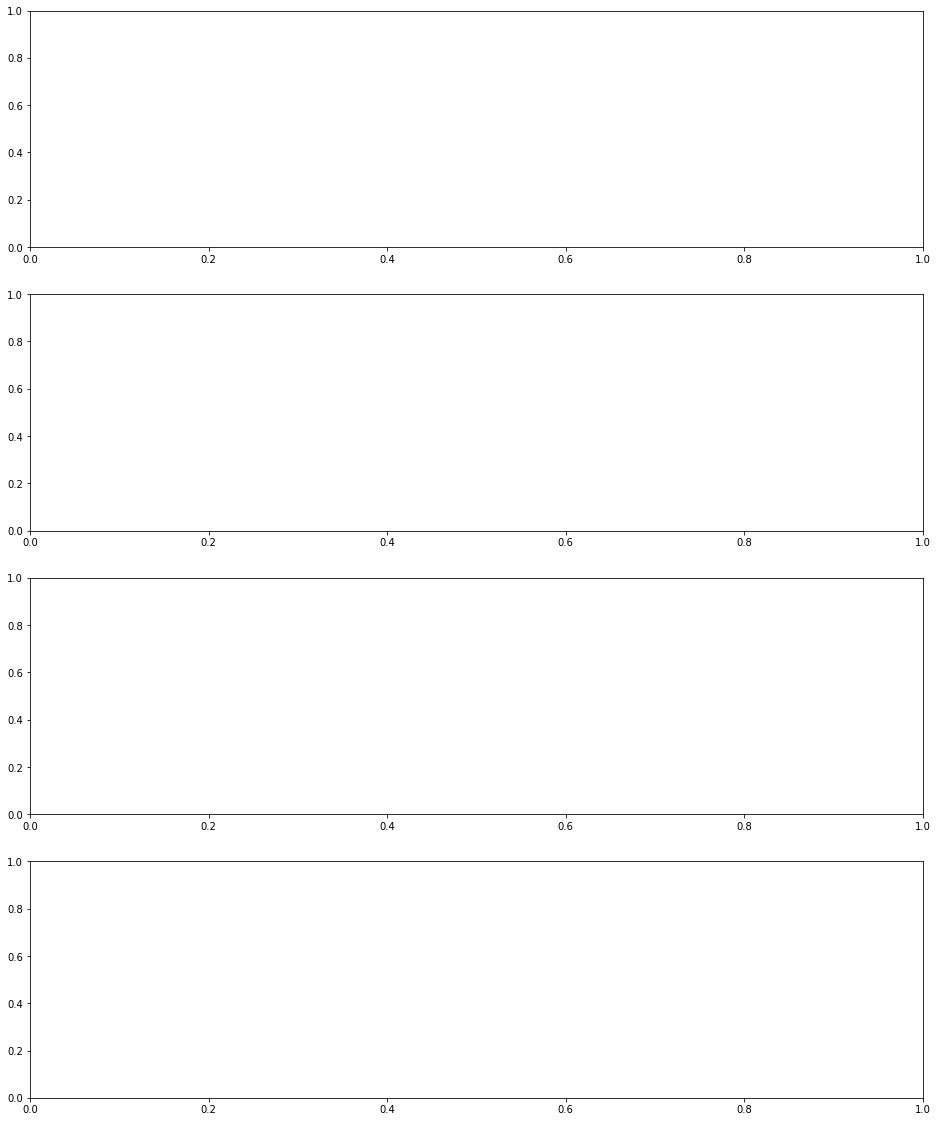

In [28]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample_002_005, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample_002_005, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample_002_005, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample_002_005, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

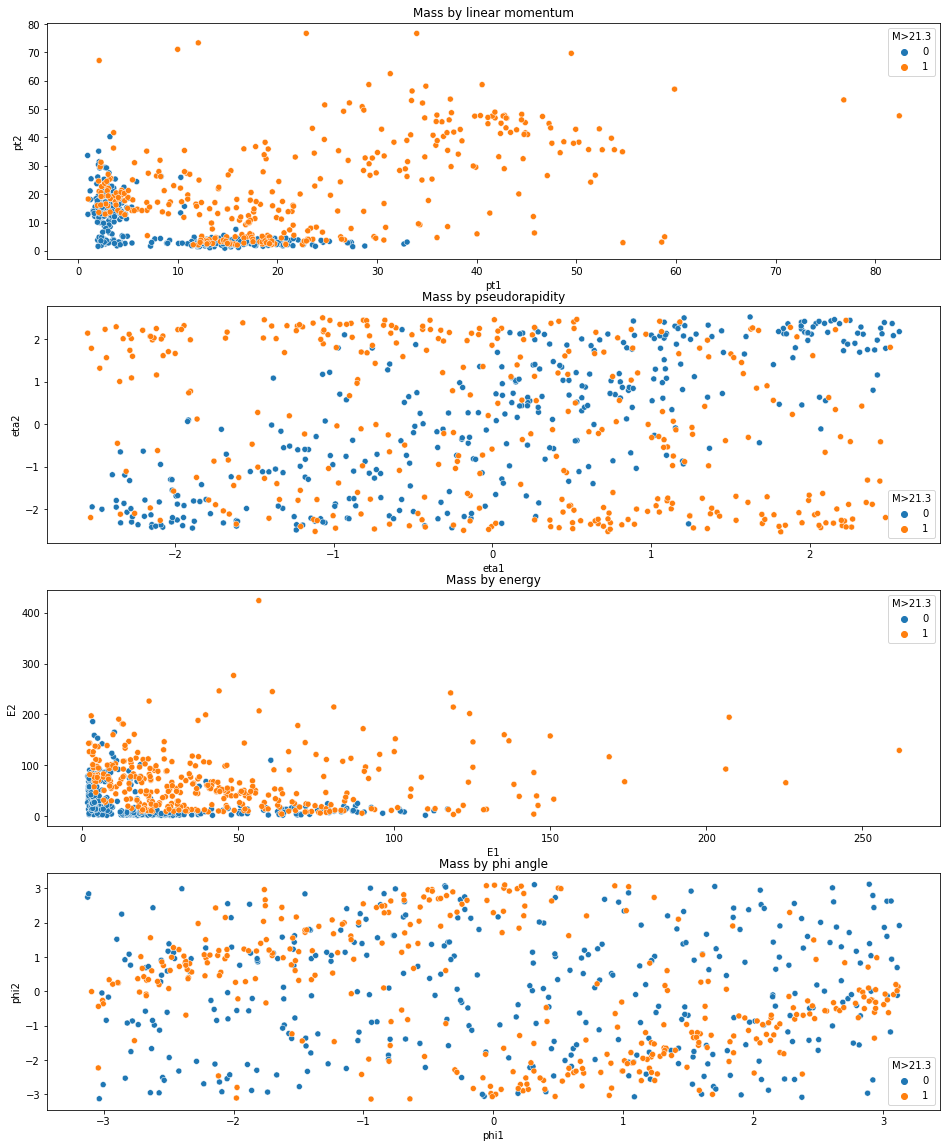

In [54]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample_004_000, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample_004_000, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample_004_000, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample_004_000, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()